In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [2]:
sns.set_style("whitegrid")

In [3]:
columns = [
    'checking_account', 'duration', 'credit_history', 'purpose', 
    'credit_amount', 'savings_account', 'employment', 'installment_rate', 
    'status_sex', 'debtors', 'residence_since', 'property', 'age', 
    'other_installment', 'housing', 'credits_existing', 'job', 
    'liables', 'telephone', 'foreign_worker', 'target'
]
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
df = pd.read_csv(url, sep=' ', header=None, names=columns)
df['target'] = df['target'].map({1: 0, 2: 1})

In [4]:
df.to_csv("german_credit_data.csv", index=False)

In [5]:
df.head()

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment,installment_rate,status_sex,debtors,...,property,age,other_installment,housing,credits_existing,job,liables,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


In [6]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
print(f"Original Train Shape: {X_train.shape}")
print(f"Original Test Shape:  {X_test.shape}")

Original Train Shape: (800, 20)
Original Test Shape:  (200, 20)


In [8]:

numeric_cols = ['duration', 'credit_amount', 'age', 'installment_rate']
train_numeric = X_train[numeric_cols].copy()
train_numeric = sm.add_constant(train_numeric)

# Fit Diagnostic Model
model = sm.GLM(y_train, train_numeric, family=sm.families.Binomial()).fit()
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Define 10% Limit
max_removable = int(len(X_train) * 0.10)
n = len(X_train)
standard_threshold = 4 / n

# Identify outliers
outlier_indices = np.where(cooks_d > standard_threshold)[0]
num_outliers = len(outlier_indices)

print(f"\n--- Outlier Detection Results ---")
print(f"Standard Threshold identified {num_outliers} outliers.")

# LOGIC: Check if we exceed the 10% limit
if num_outliers > max_removable:
    print(f"⚠️ SAFETY TRIGGERED: Limiting removal to top {max_removable} worst points (10%).")
    # Sort by Cook's D and take the top 10% indices
    top_indices = np.argsort(cooks_d)[-max_removable:]
    mask = np.ones(len(X_train), dtype=bool)
    mask[top_indices] = False
else:
    print(f"✅ Within limit. Removing all {num_outliers} detected points.")
    mask = cooks_d <= standard_threshold

# Apply Removal
X_train_clean = X_train[mask].copy()
y_train_clean = y_train[mask].copy()

print(f"Rows after cleaning: {len(X_train_clean)} (Removed: {len(X_train) - len(X_train_clean)})")
print(f"\n--- Multicollinearity Check (VIF) ---")
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols
# Recalculate VIF on cleaned data
X_vif = sm.add_constant(X_train_clean[numeric_cols])
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(numeric_cols))]
print(vif_data)
print("Note: If VIF > 10, consider dropping that COLUMN. (Rows are safe).")


--- Outlier Detection Results ---
Standard Threshold identified 45 outliers.
✅ Within limit. Removing all 45 detected points.
Rows after cleaning: 755 (Removed: 45)

--- Multicollinearity Check (VIF) ---
            Feature       VIF
0          duration  2.162089
1     credit_amount  2.312789
2               age  1.021703
3  installment_rate  1.306985
Note: If VIF > 10, consider dropping that COLUMN. (Rows are safe).



--- Anderson-Darling Test for credit_amount ---
Statistic: 37.234
Critical Values: [0.573 0.653 0.783 0.913 1.086]
>> Result: Data is NOT Normal (Statistic > Critical Value)

--- Anderson-Darling Test for age ---
Statistic: 15.739
Critical Values: [0.573 0.653 0.783 0.913 1.086]
>> Result: Data is NOT Normal (Statistic > Critical Value)


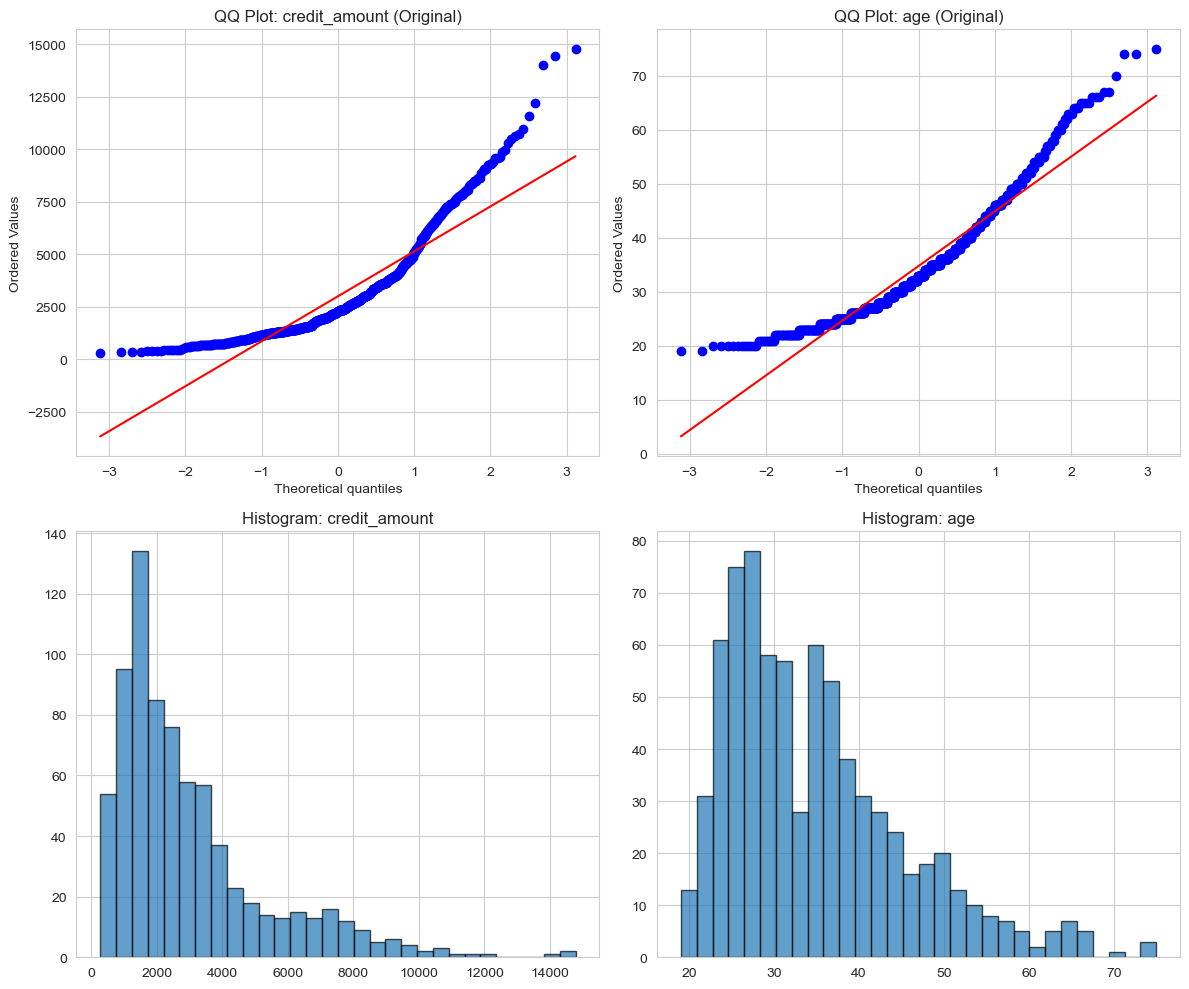

In [9]:

check_cols = ['credit_amount', 'age']

plt.figure(figsize=(12, 10))

for i, col in enumerate(check_cols):
    data = X_train_clean[col]
    result = stats.anderson(data, dist='norm')
    print(f"\n--- Anderson-Darling Test for {col} ---")
    print(f"Statistic: {result.statistic:.3f}")
    print(f"Critical Values: {result.critical_values}")
    if result.statistic > result.critical_values[2]: # Using 5% significance level
        print(f">> Result: Data is NOT Normal (Statistic > Critical Value)")
    else:
        print(f">> Result: Data looks Normal")

    plt.subplot(2, 2, i+1)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"QQ Plot: {col} (Original)")
    plt.subplot(2, 2, i+3)
    plt.hist(data, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"Histogram: {col}")

plt.tight_layout()
plt.show()

--- Anderson-Darling Test Results (After Log Transform) ---

1. Log Credit Amount
   Statistic: 1.351
   Critical Values: [0.573 0.653 0.783 0.913 1.086]
   ⚠️ RESULT: Improved, but still strictly not Gaussian (Common in finance).

2. Log Age
   Statistic: 4.552
   Critical Values: [0.573 0.653 0.783 0.913 1.086]
   ⚠️ RESULT: Improved, but still strictly not Gaussian.


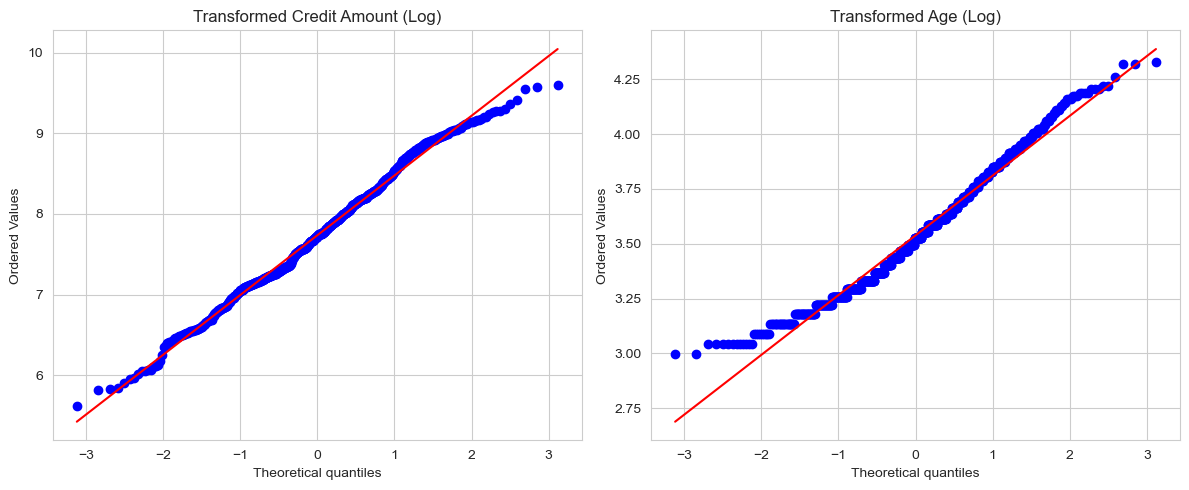

In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
X_train_clean['log_credit_amount'] = np.log1p(X_train_clean['credit_amount'])
X_test['log_credit_amount'] = np.log1p(X_test['credit_amount'])

X_train_clean['log_age'] = np.log1p(X_train_clean['age'])
X_test['log_age'] = np.log1p(X_test['age'])

print("--- Anderson-Darling Test Results (After Log Transform) ---")

result_credit = stats.anderson(X_train_clean['log_credit_amount'], dist='norm')
print(f"\n1. Log Credit Amount")
print(f"   Statistic: {result_credit.statistic:.3f}")
print(f"   Critical Values: {result_credit.critical_values}")
if result_credit.statistic < result_credit.critical_values[2]: # 5% level
    print("   ✅ RESULT: Data now looks Normal.")
else:
    print("   ⚠️ RESULT: Improved, but still strictly not Gaussian (Common in finance).")

# Check New Age
result_age = stats.anderson(X_train_clean['log_age'], dist='norm')
print(f"\n2. Log Age")
print(f"   Statistic: {result_age.statistic:.3f}")
print(f"   Critical Values: {result_age.critical_values}")
if result_age.statistic < result_age.critical_values[2]:
    print("   ✅ RESULT: Data now looks Normal.")
else:
    print("   ⚠️ RESULT: Improved, but still strictly not Gaussian.")


plt.figure(figsize=(12, 5))

# Plot Transformed Credit Amount
plt.subplot(1, 2, 1)
stats.probplot(X_train_clean['log_credit_amount'], dist="norm", plot=plt)
plt.title("Transformed Credit Amount (Log)")

# Plot Transformed Age
plt.subplot(1, 2, 2)
stats.probplot(X_train_clean['log_age'], dist="norm", plot=plt)
plt.title("Transformed Age (Log)")

plt.tight_layout()
plt.show()

In [11]:
# ---------------------------------------------------------
# 1. DEFINE FINAL FEATURES
# ---------------------------------------------------------
# We use the NEW 'log_' columns and DROP the old raw columns
numeric_features = ['duration', 'log_credit_amount', 'log_age', 'installment_rate', 
                    'residence_since', 'credits_existing', 'liables']

# Categorical features remain the same
categorical_features = ['checking_account', 'credit_history', 'purpose', 'savings_account', 
                        'employment', 'status_sex', 'debtors', 'property', 
                        'other_installment', 'housing', 'job', 'telephone', 'foreign_worker']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # Z-Score Normalization
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Fit on Train, Transform on Test
X_train_final = preprocessor.fit_transform(X_train_clean)
X_test_final = preprocessor.transform(X_test)

print(f"Final Data Shape for Modeling: {X_train_final.shape}")

NameError: name 'ColumnTransformer' is not defined

In [ ]:




# 1. Transform Train Data (Cleaned version)
X_train_clean['log_credit_amount'] = np.log1p(X_train_clean['credit_amount'])
X_train_clean['log_age'] = np.log1p(X_train_clean['age'])

# 2. Transform Test Data (Must apply same rule)
X_test['log_credit_amount'] = np.log1p(X_test['credit_amount'])
X_test['log_age'] = np.log1p(X_test['age'])

print("✅ Log Transformations applied to Train and Test.")

# ---------------------------------------------------------
# STEP 2: DEFINE FEATURES FOR ENCODING
# ---------------------------------------------------------
# We use the NEW 'log_' columns and IGNORE the old raw columns
numeric_features = [
    'duration', 
    'log_credit_amount',  # Used instead of credit_amount
    'log_age',            # Used instead of age
    'installment_rate', 
    'residence_since', 
    'credits_existing', 
    'liables'
]

categorical_features = [
    'checking_account', 'credit_history', 'purpose', 'savings_account', 
    'employment', 'status_sex', 'debtors', 'property', 
    'other_installment', 'housing', 'job', 'telephone', 'foreign_worker'
]

# ---------------------------------------------------------
# STEP 3: FINAL PREPROCESSING PIPELINE (Scaling + Encoding)
# ---------------------------------------------------------
# This converts everything to numbers (Matrix format)

preprocessor = ColumnTransformer(
    transformers=[
        # 1. Standardize Numeric Columns (Z-Score: Mean=0, Std=1)
        ('num', StandardScaler(), numeric_features),
        
        # 2. One-Hot Encode Categorical Columns (Text -> Binary 0/1)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# FIT on Train, TRANSFORM on Test
# This learns the Mean/Variance only from the Training data to avoid leakage
X_train_final = preprocessor.fit_transform(X_train_clean)
X_test_final = preprocessor.transform(X_test)

# Align the Target variables
y_train_final = y_train_clean # The targets corresponding to the cleaned train set
y_test_final = y_test         # The original test targets


print("-" * 40)
print("DATASET READY FOR MODELING")
print("-" * 40)
print(f"Training Features Shape: {X_train_final.shape}")
print(f"Training Target Shape:   {y_train_final.shape}")
print(f"Test Features Shape:     {X_test_final.shape}")
print(f"Test Target Shape:       {y_test_final.shape}")
print("-" * 40)
print("You can now pass 'X_train_final' and 'y_train_final' into your models.")

✅ Log Transformations applied to Train and Test.
----------------------------------------
DATASET READY FOR MODELING
----------------------------------------
Training Features Shape: (755, 61)
Training Target Shape:   (755,)
Test Features Shape:     (200, 61)
Test Target Shape:       (200,)
----------------------------------------
You can now pass 'X_train_final' and 'y_train_final' into your models.


In [ ]:


def plot_simple_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

Training Logistic Regression...


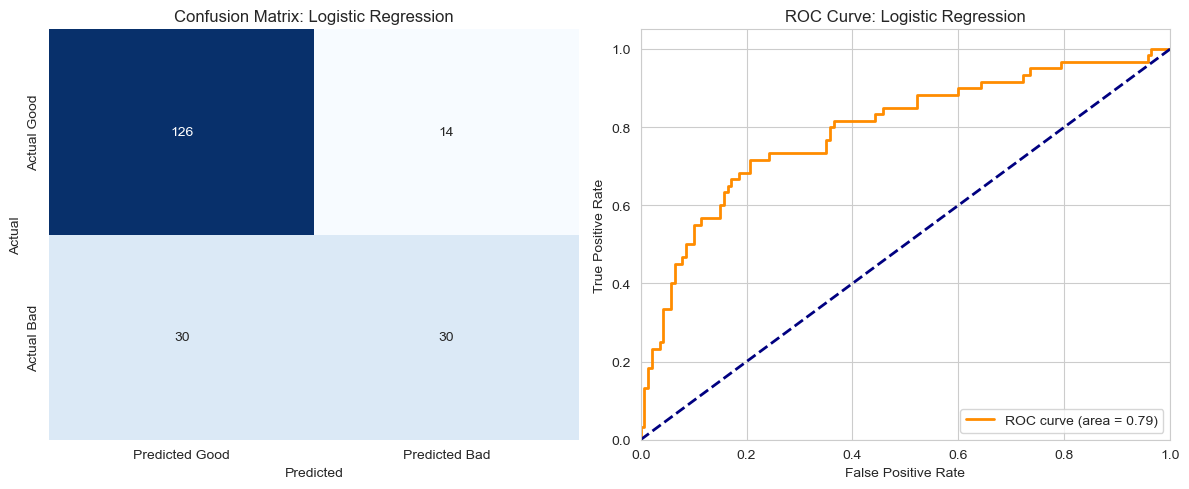

--- Logistic Regression Results ---
Accuracy: 0.7800
ROC-AUC:  0.7931

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       140
           1       0.68      0.50      0.58        60

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

if 'all_model_results' not in locals():
    all_model_results = []
model_name = "Logistic Regression"
log_reg = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')

print(f"Training {model_name}...")
log_reg.fit(X_train_final, y_train_final)
y_pred = log_reg.predict(X_test_final)                 # Class (0 or 1)
y_prob = log_reg.predict_proba(X_test_final)[:, 1]     # Probability (0.0 to 1.0)

acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)
cm = confusion_matrix(y_test_final, y_pred)

# Save for final comparison
all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0] # The most dangerous error in banking
})


plt.figure(figsize=(12, 5))

# Plot A: Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'])
plt.title(f'Confusion Matrix: {model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Plot B: ROC Curve (Essential for Research Papers)
fpr, tpr, thresholds = roc_curve(y_test_final, y_prob)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: {model_name}')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))

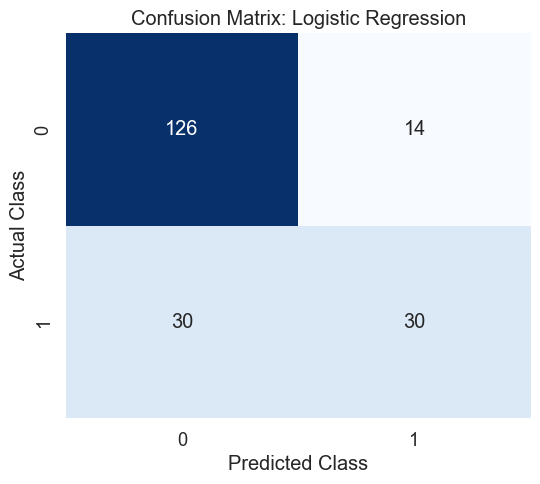

In [ ]:
plot_simple_matrix(y_test_final, y_pred, "Logistic Regression")

Training Decision Tree...
--- Decision Tree Results ---
Accuracy: 0.6400
ROC-AUC:  0.6205

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       140
           1       0.41      0.43      0.42        60

    accuracy                           0.64       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.65      0.64      0.64       200



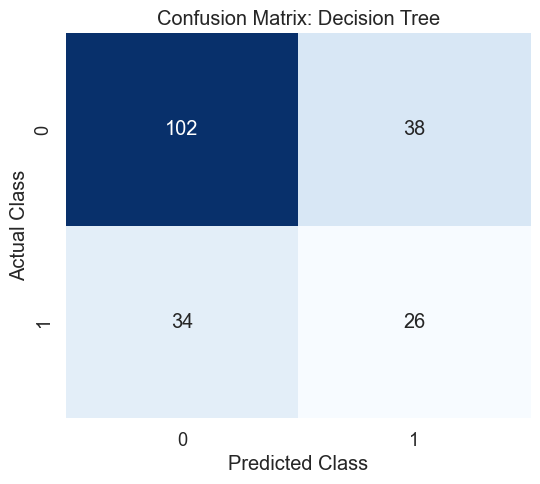

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

model_name = "Decision Tree"

dt_model = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)

print(f"Training {model_name}...")
dt_model.fit(X_train_final, y_train_final)


y_pred = dt_model.predict(X_test_final)
y_prob = dt_model.predict_proba(X_test_final)[:, 1]


acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)

cm = confusion_matrix(y_test_final, y_pred)


all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0]
})

print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
plot_simple_matrix(y_test_final, y_pred, model_name)

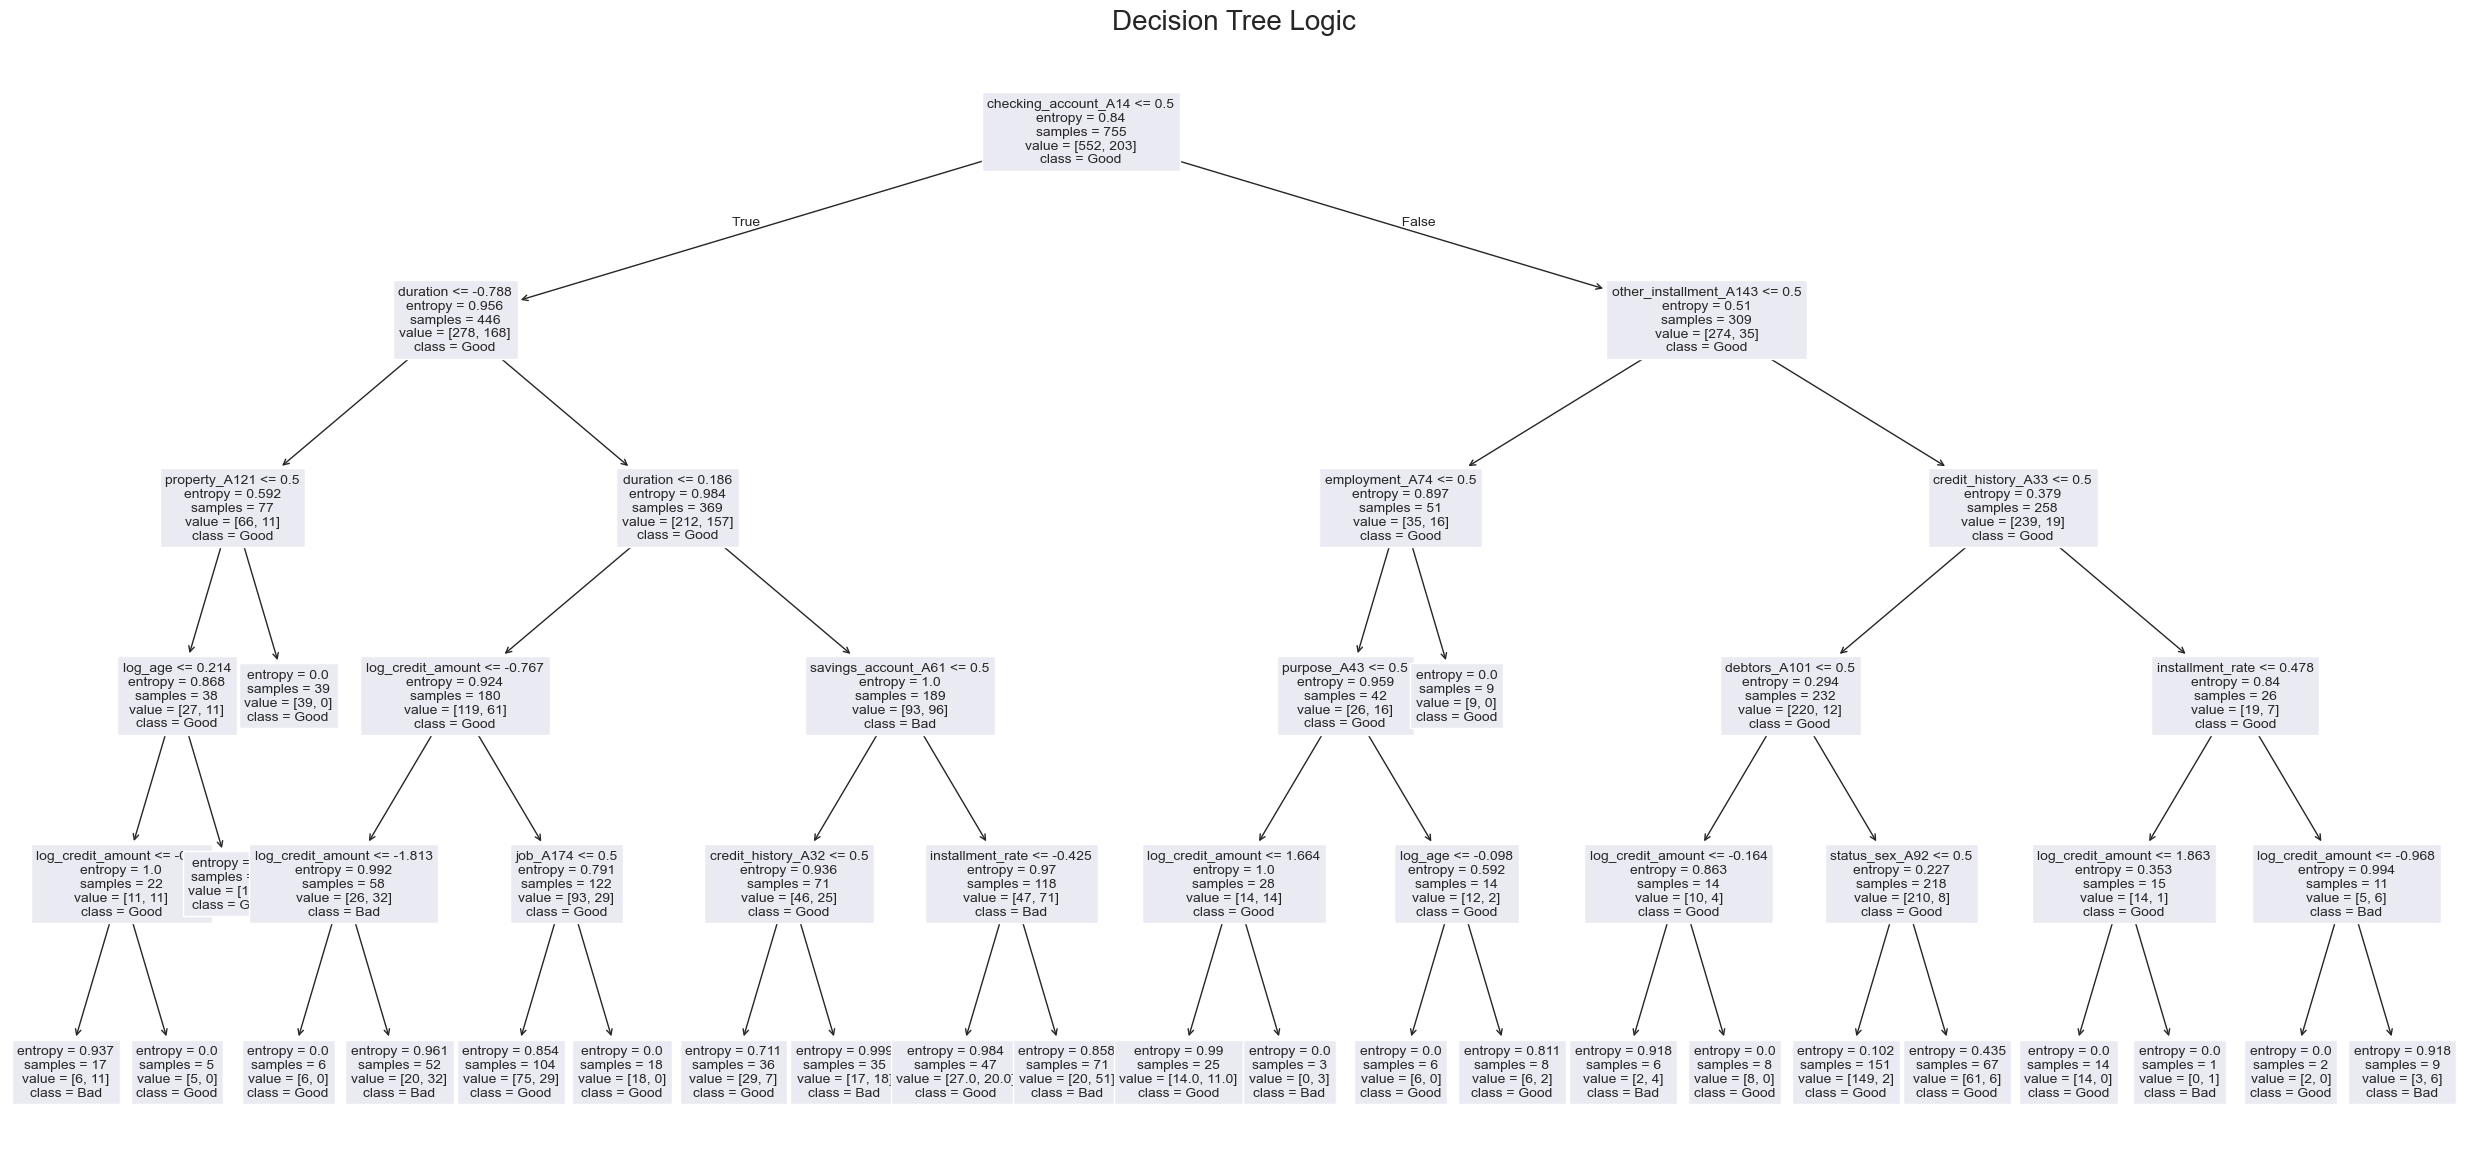

In [ ]:
from sklearn.tree import plot_tree
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine them (Numeric + Encoded)
feature_names_list = numeric_features + list(onehot_columns)

# ---------------------------------------------------------
# 2. PLOT THE TREE
# ---------------------------------------------------------
plt.figure(figsize=(25, 12)) # Huge size so text fits

plot_tree(dt_model, 
          feature_names=feature_names_list,  # Use the correct names
          class_names=['Good', 'Bad'],       # Target labels
          fontsize=10,                       # Text size
          )                       # Limit depth to 3 for readability in paper

plt.title("Decision Tree Logic", fontsize=20)
plt.tight_layout()
plt.show()

Training Random Forest...
--- Random Forest Results ---
Accuracy: 0.7700
ROC-AUC:  0.7999

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       140
           1       0.75      0.35      0.48        60

    accuracy                           0.77       200
   macro avg       0.76      0.65      0.66       200
weighted avg       0.77      0.77      0.74       200



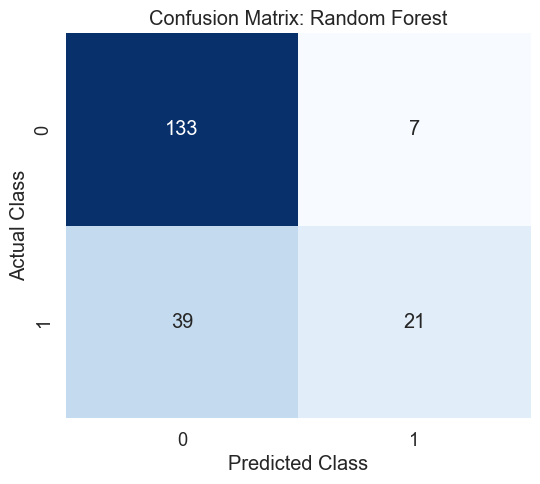

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_name = "Random Forest"
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

print(f"Training {model_name}...")
rf_model.fit(X_train_final, y_train_final)
y_pred = rf_model.predict(X_test_final)
y_prob = rf_model.predict_proba(X_test_final)[:, 1]
acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)
cm = confusion_matrix(y_test_final, y_pred)

all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0]
})
print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
plot_simple_matrix(y_test_final, y_pred, model_name)

Training XGBoost...
--- XGBoost Results ---
Accuracy: 0.7300
ROC-AUC:  0.7189

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       140
           1       0.57      0.42      0.48        60

    accuracy                           0.73       200
   macro avg       0.67      0.64      0.65       200
weighted avg       0.71      0.73      0.72       200



/Users/chintan/miniconda3/envs/dl/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


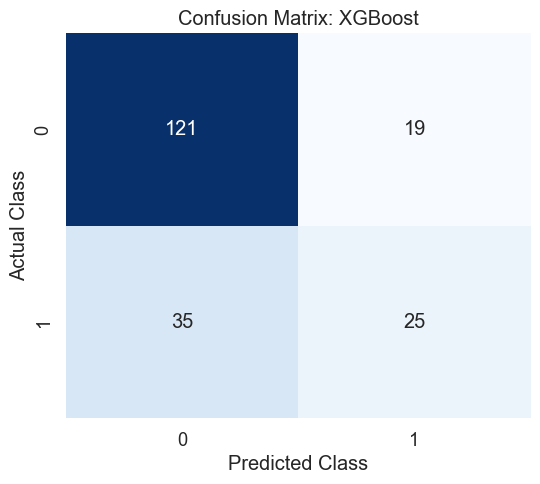

In [ ]:
import xgboost as xgb
model_name = "XGBoost"
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

print(f"Training {model_name}...")
xgb_model.fit(X_train_final, y_train_final)
y_pred = xgb_model.predict(X_test_final)
y_prob = xgb_model.predict_proba(X_test_final)[:, 1]


acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)
cm = confusion_matrix(y_test_final, y_pred)

# Add to the Master List
all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0]
})

print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))

# Plot Matrix
plot_simple_matrix(y_test_final, y_pred, model_name)

Training SVM...
--- SVM Results ---
Accuracy: 0.7950
ROC-AUC:  0.7805

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       140
           1       0.81      0.42      0.55        60

    accuracy                           0.80       200
   macro avg       0.80      0.69      0.71       200
weighted avg       0.80      0.80      0.77       200



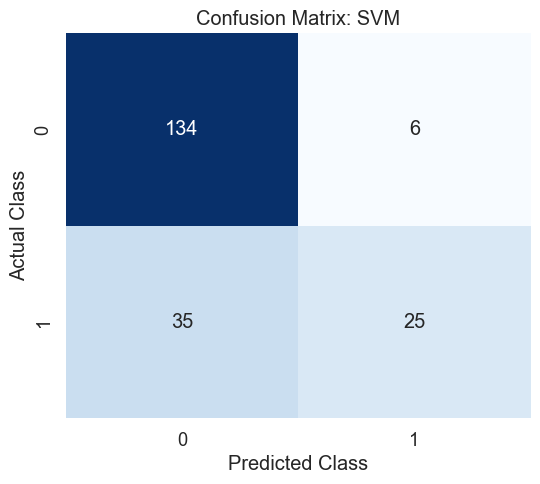

In [ ]:
from sklearn.svm import SVC
model_name = "SVM"

svm_model = SVC(kernel='rbf', probability=True, random_state=42)

print(f"Training {model_name}...")
svm_model.fit(X_train_final, y_train_final)

y_pred = svm_model.predict(X_test_final)
y_prob = svm_model.predict_proba(X_test_final)[:, 1]


acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)
cm = confusion_matrix(y_test_final, y_pred)

# Add to the Master List
all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0]
})

print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
plot_simple_matrix(y_test_final, y_pred, model_name)

Training KNN...
--- KNN Results ---
Accuracy: 0.7450
ROC-AUC:  0.7090

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.84       140
           1       0.68      0.28      0.40        60

    accuracy                           0.74       200
   macro avg       0.72      0.61      0.62       200
weighted avg       0.73      0.74      0.71       200



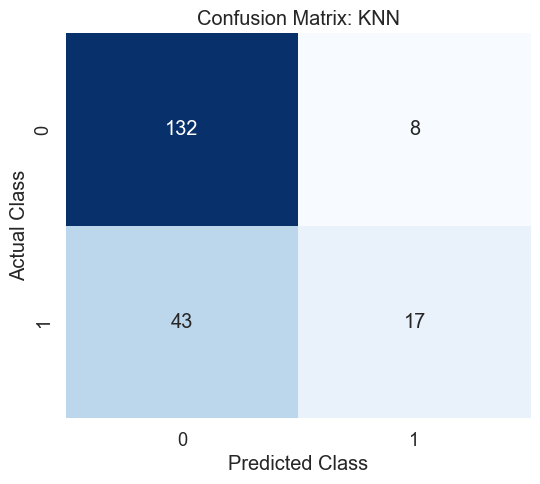

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_name = "KNN"


knn_model = KNeighborsClassifier(n_neighbors=15, metric='minkowski', p=2)

print(f"Training {model_name}...")
knn_model.fit(X_train_final, y_train_final)


y_pred = knn_model.predict(X_test_final)
y_prob = knn_model.predict_proba(X_test_final)[:, 1]

acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)
cm = confusion_matrix(y_test_final, y_pred)


all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0]
})


print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
plot_simple_matrix(y_test_final, y_pred, model_name)

Training LightGBM...
--- LightGBM Results ---
Accuracy: 0.7600
ROC-AUC:  0.7426

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       140
           1       0.65      0.43      0.52        60

    accuracy                           0.76       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.76      0.74       200



/Users/chintan/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/chintan/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


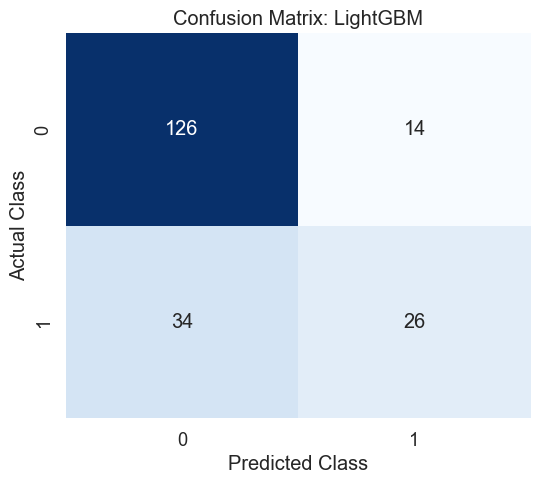

In [ ]:
import lightgbm as lgb

model_name = "LightGBM"
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

print(f"Training {model_name}...")
lgb_model.fit(X_train_final, y_train_final)
y_pred = lgb_model.predict(X_test_final)
y_prob = lgb_model.predict_proba(X_test_final)[:, 1]
acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)
cm = confusion_matrix(y_test_final, y_pred)
all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0]
})
print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
plot_simple_matrix(y_test_final, y_pred, model_name)

Training Neural Network...
--- Neural Network Results ---
Accuracy: 0.7550
ROC-AUC:  0.7711

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       140
           1       0.60      0.55      0.57        60

    accuracy                           0.76       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.75      0.76      0.75       200



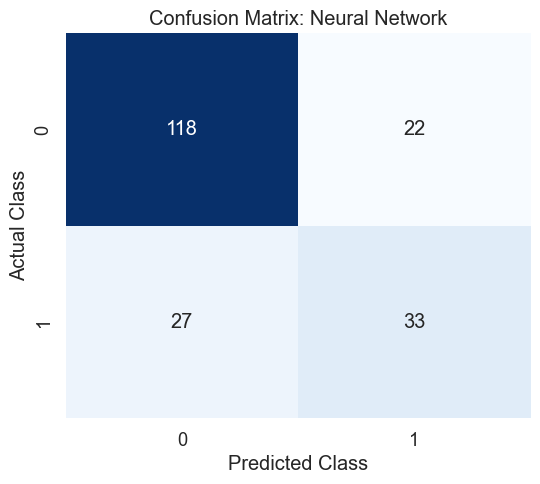

In [ ]:
from sklearn.neural_network import MLPClassifier
model_name = "Neural Network"
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), 
                          activation='relu', 
                          solver='adam', 
                          max_iter=1000, 
                          random_state=42)

print(f"Training {model_name}...")
mlp_model.fit(X_train_final, y_train_final)
y_pred = mlp_model.predict(X_test_final)
y_prob = mlp_model.predict_proba(X_test_final)[:, 1]
acc = accuracy_score(y_test_final, y_pred)
roc = roc_auc_score(y_test_final, y_prob)
cm = confusion_matrix(y_test_final, y_pred)

# Add to the Master List
all_model_results.append({
    'Model': model_name,
    'Accuracy': acc,
    'ROC-AUC': roc,
    'False Negatives': cm[1][0]
})
print(f"--- {model_name} Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
plot_simple_matrix(y_test_final, y_pred, model_name)

--- FINAL MODEL LEADERBOARD ---
                 Model  Accuracy   ROC-AUC  False Negatives
0        Random Forest     0.770  0.799881               39
1  Logistic Regression     0.780  0.793095               30
2                  SVM     0.795  0.780476               35
3       Neural Network     0.755  0.771071               27
4             LightGBM     0.760  0.742619               34
5              XGBoost     0.730  0.718929               35
6                  KNN     0.745  0.708988               43
7        Decision Tree     0.640  0.620476               34


/Users/chintan/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


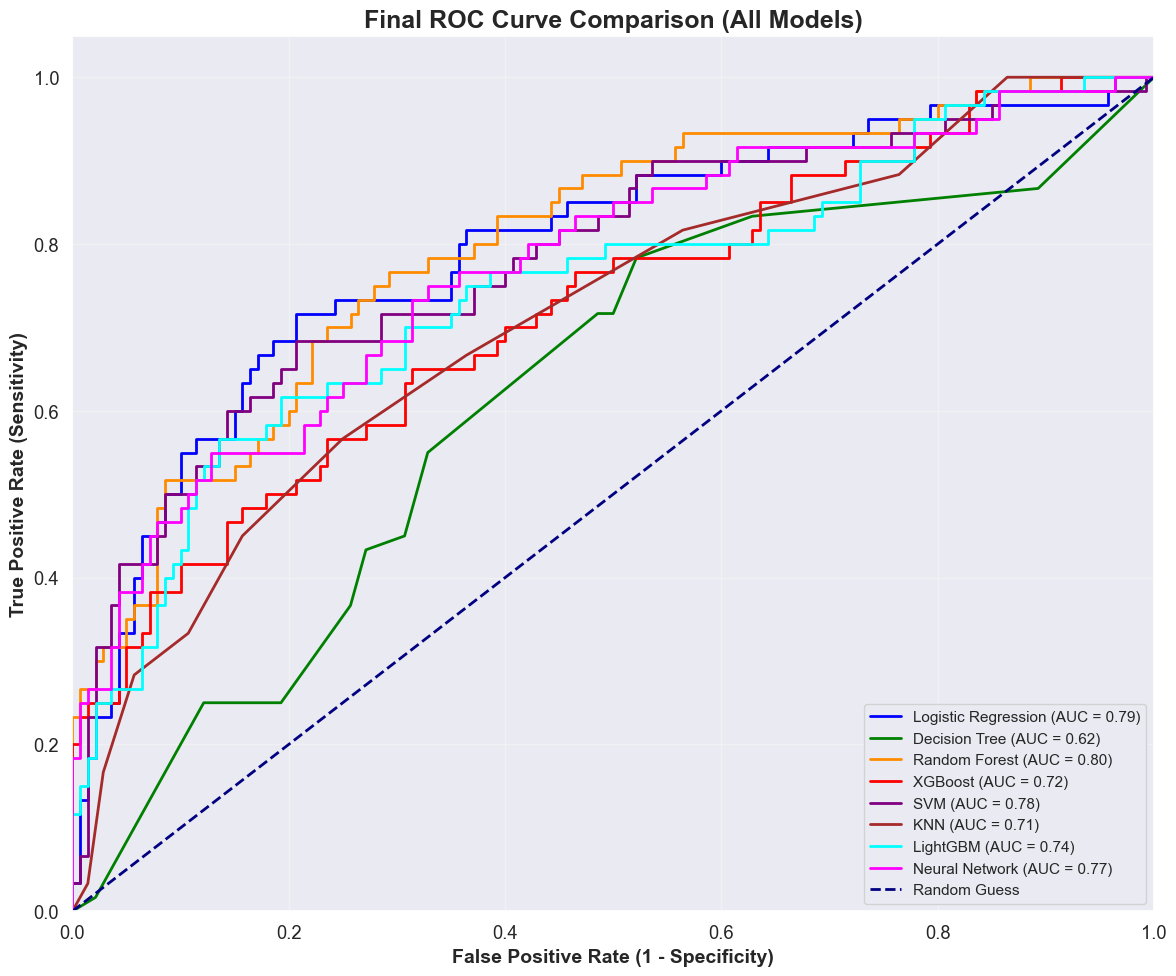

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
leaderboard = pd.DataFrame(all_model_results)

leaderboard = leaderboard.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

print("--- FINAL MODEL LEADERBOARD ---")
print(leaderboard)

plt.figure(figsize=(12, 10))


models_dict = {
    'Logistic Regression': log_reg,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'SVM': svm_model,
    'KNN': knn_model,
    'LightGBM': lgb_model,
    'Neural Network': mlp_model
}


colors = ['blue', 'green', 'darkorange', 'red', 'purple', 'brown', 'cyan', 'magenta']
color_idx = 0


for name, model in models_dict.items():

    y_prob = model.predict_proba(X_test_final)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_final, y_prob)
    auc_score = roc_auc_score(y_test_final, y_prob)
    plt.plot(fpr, tpr, lw=2, color=colors[color_idx], label=f'{name} (AUC = {auc_score:.2f})')
    color_idx += 1


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14, weight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14, weight='bold')
plt.title('Final ROC Curve Comparison (All Models)', fontsize=18, weight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()